In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  
import os
import json
import numpy as np

In [2]:
def process_recording(recording_path):
   
    with open(recording_path) as recording_file:
        data = json.load(recording_file)
        player_actions = pd.DataFrame(data["player"])
        #print("player_actions", player_actions)
        ai_moves = data["ai"]
        
        # Defininf Action_Start, Action_End and Action_Duration 
        player_actions['action_start'] = pd.to_datetime(player_actions['action_start'])
        player_actions['action_end'] = pd.to_datetime(player_actions['action_end'])
        player_actions['duration'] = (player_actions['action_end'] - player_actions['action_start']).dt.total_seconds()
        
        
        # Speech Actions Statistics 
        speech_actions = player_actions[player_actions['action_type'] == 'speech']
        #print("speech_actions", speech_actions)
        
        if not speech_actions.empty:
            length_speech_actions = len(speech_actions)  # just the length of the recorded timestamps
            total_utterances = speech_actions['utterances'].sum()   # it is the numer of expression said during a time interval  
            legal_speech_actions = sum(len(action) for action in speech_actions['moves'])
            illegal_speech_actions = total_utterances - legal_speech_actions
            average_speech_duration = speech_actions['duration'].mean()
            total_speech_duration = speech_actions['duration'].sum() / 60 
        else:
            length_speech_actions = 0
            total_utterances = 0
            legal_speech_actions = 0
            illegal_speech_actions = 0
            average_speech_duration = 0
            total_speech_duration = 0
        
        # Hand Actions Statistics 
        hand_actions = player_actions[player_actions['action_type'] == 'hand']
        length_hand_actions = len(hand_actions)   # just the length of the recorded timestamps
        total_hand_down_buttons = hand_actions['down_button'].sum()   # It is the total number of actions performed by the hand 
        legal_hand_actions = sum(len(action) for action in hand_actions['moves'])
        illegal_hand_actions = total_hand_down_buttons - legal_hand_actions
        total_hand_distance = hand_actions['action_dist'].sum()
        average_hand_duration = hand_actions['duration'].mean()
        total_hand_duration = hand_actions['duration'].sum() / 60
        total_hand_up_buttons = hand_actions['up_button'].sum()
        
        # Mouse Actions Statistics 
        mouse_actions =  player_actions[player_actions['action_type'] == 'mouse']
        length_mouse_actions = len(mouse_actions)   # just the length of the recorded timestamps 
        total_mouse_down_buttons = mouse_actions['down_button'].sum()   # It is the total number of actions performed by the mouse
        legal_mouse_actions = sum(len(action) for action in mouse_actions['moves'])
        illegal_mouse_actions = total_mouse_down_buttons - legal_mouse_actions
        total_mouse_distance = mouse_actions['action_dist'].sum()
        total_mouse_duration = mouse_actions['duration'].sum() / 60
        average_mouse_duration = mouse_actions['duration'].mean()
        total_mouse_up_buttons =  mouse_actions['up_button'].sum()
        
        
        # AI Actions Statistics 
        total_ai_moves = len(ai_moves)
        
        # I think these metrics don't have much sense, but they are global metrics 
        total_actions = total_utterances + total_hand_down_buttons + total_mouse_down_buttons
        total_legal_actions = legal_speech_actions + legal_hand_actions + legal_mouse_actions
        total_illegal_actions = total_actions - total_legal_actions
        
    
        return {
            "length_speech_actions": length_speech_actions,
            "total_utterances": total_utterances,
            "legal_speech_actions": legal_speech_actions,
            "illegal_speech_actions": illegal_speech_actions,
            "average_speech_duration": average_speech_duration,
            "total_speech_duration": total_speech_duration,
            "length_hand_actions" : length_hand_actions,
            "total_hand_down_buttons": total_hand_down_buttons,
            "legal_hand_actions": legal_hand_actions,
            "illegal_hand_actions": illegal_hand_actions,
            "total_hand_distance": total_hand_distance,
            "average_hand_duration": average_hand_duration,
            "total_hand_duration": total_hand_duration,
            "total_hand_up_buttons": total_hand_up_buttons,
            "length_mouse_actions" : length_mouse_actions,
            "total_mouse_down_buttons": total_mouse_down_buttons,
            "legal_mouse_actions": legal_mouse_actions,
            "illegal_mouse_actions": illegal_mouse_actions,
            "total_mouse_distance" : total_mouse_distance,
            "total_mouse_duration" : total_mouse_duration,
            "average_mouse_duration" : average_mouse_duration,
            "total_mouse_up_buttons" : total_mouse_up_buttons,
            "total_ai_moves": total_ai_moves,
            "total_actions": total_actions,
            "total_legal_actions": total_legal_actions,
            "total_illegal_actions": total_illegal_actions
        }

def standardize_recording_name(filename):
    # Extracting name up to first _ 
    base_name = filename.split("_")[0]
    return base_name


directory = 'recordings/'
 
all_stats = {}

for filename in os.listdir(directory):
    if filename.endswith(".json"):
        recording_path = os.path.join(directory, filename)
        recording_stats = process_recording(recording_path)
        standardized_name = standardize_recording_name(filename)
        
        if standardized_name not in all_stats:
            all_stats[standardized_name] = recording_stats
        else:
            for key in all_stats[standardized_name]:
                #print(key , (type(all_stats[standardized_name][key])))
                if not key.startswith("average_"):
                    all_stats[standardized_name][key] += recording_stats[key]
                elif key.startswith("average_"):
                    continue
        
        
            # Recomputing averages after summing
            all_stats[standardized_name]['average_speech_duration'] = all_stats[standardized_name]['total_speech_duration'] / all_stats[standardized_name]['length_speech_actions'] if all_stats[standardized_name]['length_speech_actions'] > 0 else 0
            all_stats[standardized_name]['average_hand_duration'] = all_stats[standardized_name]['total_hand_duration'] / all_stats[standardized_name]['length_hand_actions'] if all_stats[standardized_name]['length_hand_actions'] > 0 else 0
            all_stats[standardized_name]['average_mouse_duration'] = all_stats[standardized_name]['total_mouse_duration'] / all_stats[standardized_name]['length_mouse_actions'] if all_stats[standardized_name]['length_mouse_actions'] > 0 else 0


df = pd.DataFrame.from_dict(all_stats, orient='index')

df.index.name = 'recording'

df.reset_index(inplace=True)

#df = df.transpose()

#print(df)



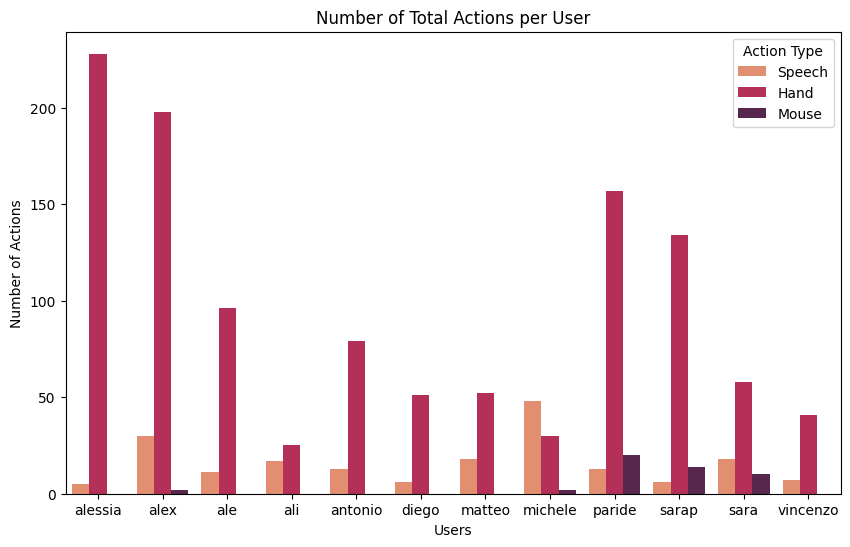

In [3]:
# Number of Total Actions per User
df_melted = df.melt(id_vars=['recording'], value_vars=['total_utterances', 'total_hand_down_buttons', 'total_mouse_down_buttons'],
                    var_name='Action Type', value_name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='recording', y= 'Count', hue='Action Type', palette = "rocket_r")
plt.title('Number of Total Actions per User')
plt.xlabel('Users')
plt.ylabel('Number of Actions')

handles, labels = plt.gca().get_legend_handles_labels()
custom_legend = plt.legend(handles=handles, labels=['Speech', 'Hand', 'Mouse'], title='Action Type')
plt.show()


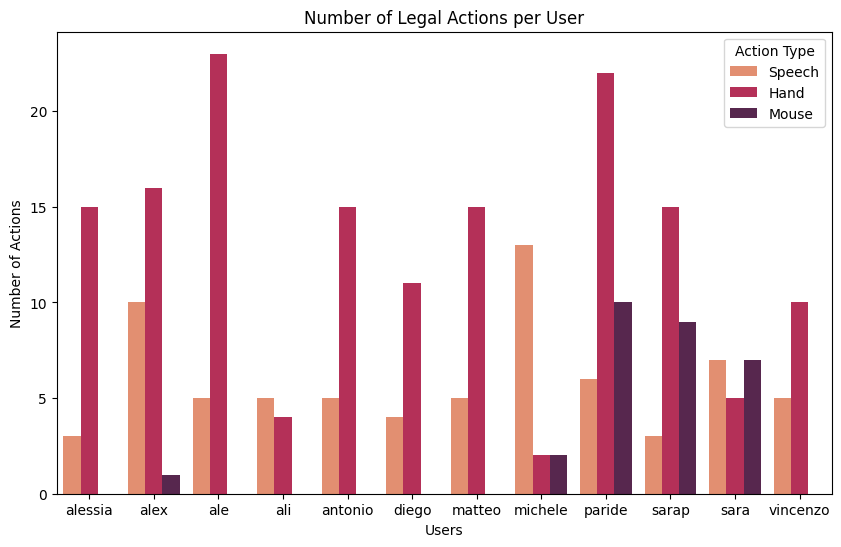

In [4]:
# Number of Legal Actions per User
df_melted = df.melt(id_vars=['recording'], value_vars=['legal_speech_actions', 'legal_hand_actions', 'legal_mouse_actions'],
                    var_name='Action Type', value_name='Count')


plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='recording', y= 'Count', hue='Action Type', palette = "rocket_r")
plt.title('Number of Legal Actions per User')
plt.xlabel('Users')
plt.ylabel('Number of Actions')
handles, labels = plt.gca().get_legend_handles_labels()
custom_legend = plt.legend(handles=handles, labels=['Speech', 'Hand', 'Mouse'], title='Action Type')
plt.show()


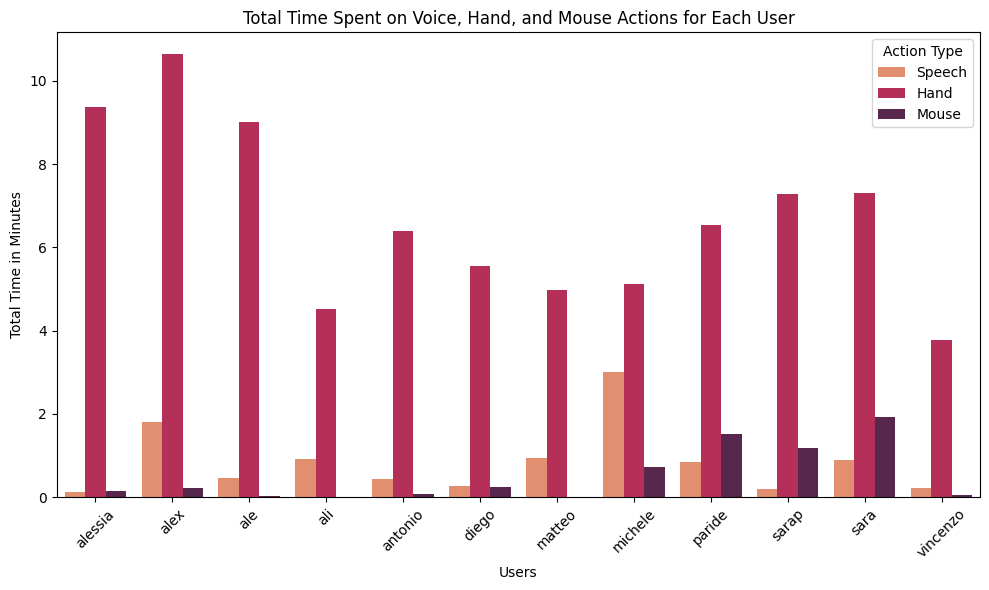

In [5]:
# Total Time Spent on Voice, Hand, and Mouse Actions for Each User
melted_df = df.melt(id_vars = ['recording'], value_vars=['total_speech_duration', 'total_hand_duration', 'total_mouse_duration'], 
                     var_name='Action Type', value_name='Total Time in minutes')

plt.figure(figsize=(10, 6))

sns.barplot(data=melted_df, x='recording', y='Total Time in minutes', hue='Action Type', palette="rocket_r")
plt.xlabel('Users')
plt.ylabel('Total Time in Minutes')
plt.title('Total Time Spent on Voice, Hand, and Mouse Actions for Each User')
plt.xticks(rotation=45)
plt.legend(title='Action Type')
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
custom_legend = plt.legend(handles=handles, labels=['Speech', 'Hand', 'Mouse'], title='Action Type')
plt.show()


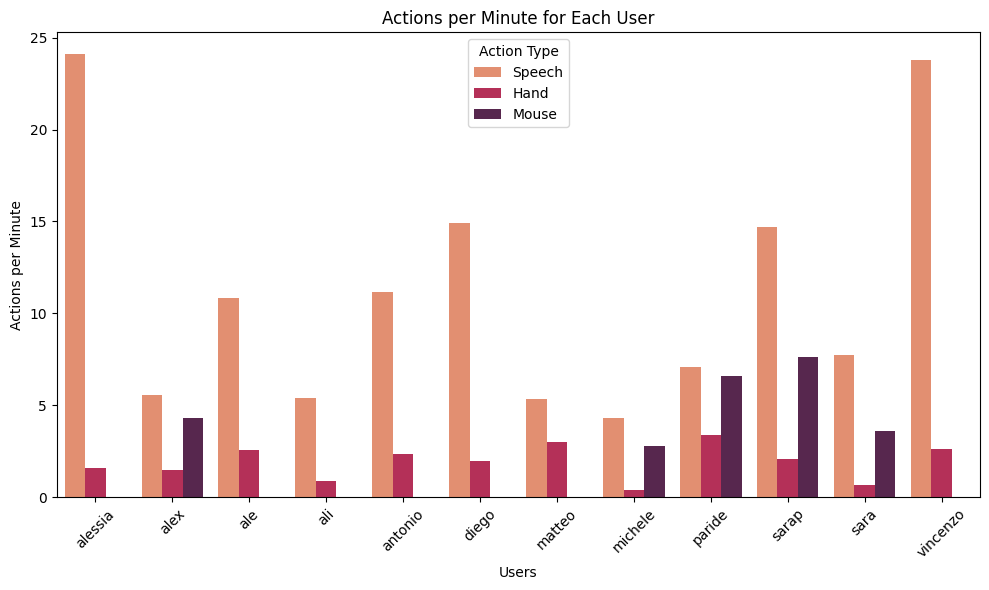

In [6]:
# Actions per Minute plot 
df['speech_actions_per_minute'] = df['legal_speech_actions'] / (df['total_speech_duration'])
df['hand_actions_per_minute'] = df['legal_hand_actions'] / (df['total_hand_duration'] )
df['mouse_actions_per_minute'] = df['legal_mouse_actions'] / (df['total_mouse_duration'])

df_melted = df.melt(id_vars=['recording'], value_vars=['speech_actions_per_minute', 'hand_actions_per_minute', 'mouse_actions_per_minute'], 
                    var_name='Action Type', value_name='Actions per Minute')

# Using barplot instead of histplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='recording', y='Actions per Minute', hue='Action Type', palette='rocket_r')

plt.xlabel('Users')
plt.ylabel('Actions per Minute')
plt.title('Actions per Minute for Each User')
plt.xticks(rotation=45)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
custom_legend = plt.legend(handles=handles, labels=['Speech', 'Hand', 'Mouse'], title='Action Type')
plt.show()


C:\Users\surre\AppData\Local\Temp\ipykernel_15200\266188678.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='recording', y='error_rate_speech', palette= ["#C86A86"])
C:\Users\surre\AppData\Local\Temp\ipykernel_15200\266188678.py:4: UserWarning: 
The palette list has fewer values (1) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=df, x='recording', y='error_rate_speech', palette= ["#C86A86"])


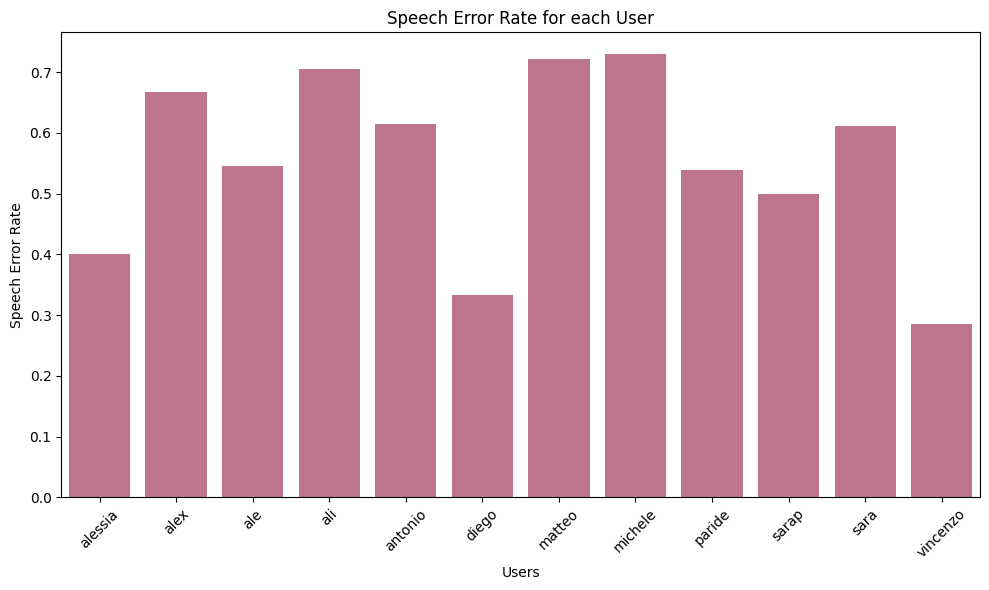

In [7]:
# Speech Error Rate 
df['error_rate_speech'] = 1 - (df['legal_speech_actions'] / df['total_utterances'])
plt.figure(figsize=(10, 6)) 
sns.barplot(data=df, x='recording', y='error_rate_speech', palette= ["#C86A86"])

plt.xlabel('Users')
plt.ylabel('Speech Error Rate')
plt.title('Speech Error Rate for each User')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

C:\Users\surre\AppData\Local\Temp\ipykernel_15200\883371427.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='recording', y='error_rate_hand', data=df, palette= ['#B87171'])
C:\Users\surre\AppData\Local\Temp\ipykernel_15200\883371427.py:5: UserWarning: 
The palette list has fewer values (1) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='recording', y='error_rate_hand', data=df, palette= ['#B87171'])


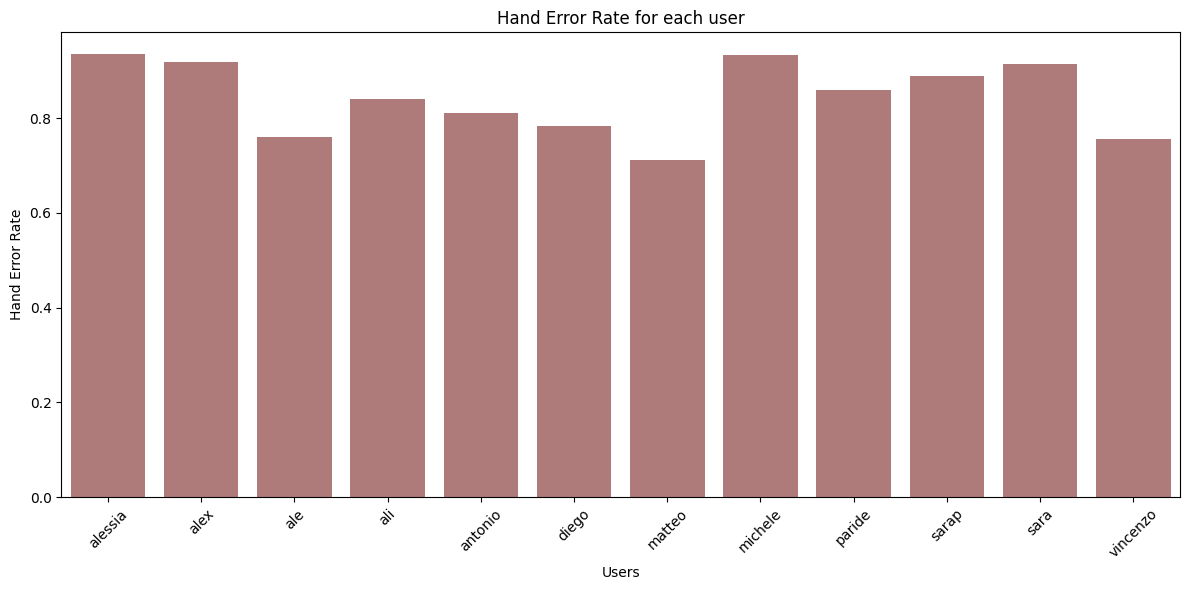

In [8]:
# Hand Error Rate  
df['error_rate_hand'] = 1 - (df['legal_hand_actions'] / df['total_hand_down_buttons'])
plt.figure(figsize=(12, 6))

sns.barplot(x='recording', y='error_rate_hand', data=df, palette= ['#B87171'])

plt.xlabel('Users')
plt.ylabel('Hand Error Rate')
plt.title('Hand Error Rate for each user')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

0
1
2
3
4
5
7
8
9
10
11
12
13
14
15


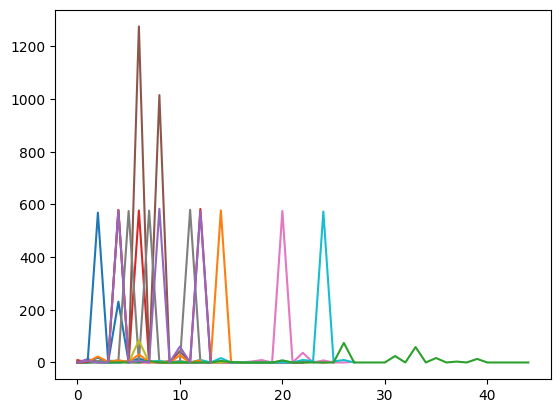

In [22]:
def process_recording2(recording_path):
   
    with open(recording_path) as recording_file:
        data = json.load(recording_file)
        player_actions = pd.DataFrame(data["player"])
        
        # Defininf Action_Start, Action_End and Action_Duration 
        player_actions['action_start'] = pd.to_datetime(player_actions['action_start'])
        player_actions['action_end'] = pd.to_datetime(player_actions['action_end'])
        player_actions['duration'] = (player_actions['action_end'] - player_actions['action_start']).dt.total_seconds()
        player_actions['apm'] = np.asarray([len(action) for action in player_actions['moves']]) / (player_actions['duration'] / 60)

        return player_actions['action_start'], player_actions['action_end'], player_actions['apm']
        

directory = 'recordings/'
apms = []
for i, filename in enumerate(os.listdir(directory)):
    if filename.endswith(".json"):
        recording_path = os.path.join(directory, filename)
        start, end, apm = process_recording2(recording_path)
        print(i)
        apms.append(apm)
        plt.plot(apm)

plt.show()